# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                         
Sample_120  P35555                                    16.555
Sample_078  A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503   15.764
Sample_143  Q8TDF5;Q8TDF5-1;Q8TDF5-2                  14.078
Sample_073  Q8NCH0                                    13.607
Sample_056  P01033;Q5H9A7                             20.055
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups 
Sample_181  Q9BYJ0            15.979
Sample_197  Q8NFP4;Q8NFP4-2   15.947
Sample_004  P54803            15.182
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.468
            A0A075B6Q5                 13.308
            A0A075B6R2                 11.736
            A0A075B6S5                 12.069
            A0A087WSY4                 13.299
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.839
            Q9UI40;Q9UI40-2            12.879
            Q9UIW2                     12.792
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.266
            Q9UP79                     13.555
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.147,15.050,16.842,19.863,15.938,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.680,19.067,...,15.528,15.576,14.094,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.016,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.523,17.705,17.039,16.052,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.418,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.531,15.345,17.084,18.708,14.249,19.433,10.829,11.161
Sample_207,15.739,16.877,15.469,16.898,14.627,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.159,13.777,12.640,12.489,13.610,12.832,12.033,11.305,12.727,12.746
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.537,19.067,16.127,...,10.830,14.386,11.364,13.451,11.817,13.663,12.653,12.576,13.234,12.766
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.672,12.815,13.203,12.465,11.195,13.141,12.695,13.647,11.638,12.753
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.398,12.298,13.608,12.549,12.974,13.272,12.898,12.061,12.881,13.489
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.166,13.003,12.466,12.482,13.264,13.554,13.258,13.447,12.497,13.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.012,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 364.50it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  9.41it/s]

100%|██████████| 2/2 [00:00<00:00,  9.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.96it/s]

100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

100%|██████████| 3/3 [00:00<00:00,  6.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.94it/s]

100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.43it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.81it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.73it/s]

100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 10.99it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.17it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  6.64it/s]

100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.14it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.72it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.61it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.77it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.82it/s]

100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

100%|██████████| 7/7 [00:01<00:00,  5.13it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.67it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.86it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.26it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.09it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.95it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.14it/s]

100%|██████████| 8/8 [00:01<00:00,  4.08it/s]

100%|██████████| 8/8 [00:01<00:00,  4.26it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.15it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.94it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.27it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.31it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.13it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.11it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.92it/s]

100%|██████████| 9/9 [00:02<00:00,  4.17it/s]

100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 11.20it/s]

 40%|████      | 4/10 [00:00<00:01,  5.88it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.38it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.68it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.38it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.25it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.45it/s]

100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.79it/s]

 36%|███▋      | 4/11 [00:00<00:00,  8.08it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.31it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  7.22it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  7.23it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  7.17it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  7.12it/s]

 91%|█████████ | 10/11 [00:01<00:00,  7.07it/s]

100%|██████████| 11/11 [00:01<00:00,  6.77it/s]

100%|██████████| 11/11 [00:01<00:00,  7.29it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 10.82it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.43it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.41it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.16it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.46it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  6.70it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  7.02it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  7.15it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  7.21it/s]

100%|██████████| 12/12 [00:01<00:00,  7.29it/s]

100%|██████████| 12/12 [00:01<00:00,  7.05it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.47it/s]

 31%|███       | 4/13 [00:00<00:01,  6.79it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.28it/s]

 46%|████▌     | 6/13 [00:00<00:01,  5.62it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.65it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.85it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.90it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.75it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.56it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  5.57it/s]

100%|██████████| 13/13 [00:02<00:00,  5.50it/s]

100%|██████████| 13/13 [00:02<00:00,  5.88it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 13.40it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.44it/s]

 36%|███▌      | 5/14 [00:00<00:01,  8.11it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.87it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.52it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  7.20it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.14it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.12it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.99it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.27it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.44it/s]

100%|██████████| 14/14 [00:01<00:00,  6.61it/s]

100%|██████████| 14/14 [00:01<00:00,  7.05it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 14.11it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.15it/s]

 40%|████      | 6/15 [00:00<00:01,  8.07it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.66it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.68it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.74it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.79it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.95it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.00it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.01it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.03it/s]

100%|██████████| 15/15 [00:02<00:00,  7.03it/s]

100%|██████████| 15/15 [00:02<00:00,  7.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.044 0.014          0.696 0.392       0.100   
2             0.004 0.003      0.041 0.014          0.711 0.091       0.599   
3             0.003 0.000      0.037 0.014          0.767 0.109       0.632   
4             0.003 0.001      0.033 0.012          0.715 0.095       0.681   
5             0.003 0.001      0.032 0.012          0.787 0.092       0.810   
6             0.003 0.002      0.041 0.017          0.785 0.091       0.814   
7             0.004 0.002      0.039 0.011          0.813 0.086       0.820   
8             0.004 0.002      0.036 0.005          0.818 0.087       0.823   
9             0.003 0.002      0.032 0.016          0.813 0.079       0.830   
10            0.003 0.002      0.035 0.013          0.809 0.082       0.831   
11            0.003 0.002      0.036 0.017          0.814 0.077       0.824   
12            0.003 0.001      0.031 0.016          0.817 0.083       0.806   
13            0.002 0.000      0.020 0.000          0.803 0.094       0.797   
14            0.002 0.000      0.021 0.004          0.801 0.095       0.799   
15            0.002 0.001      0.022 0.004          0.799 0.093       0.793   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.167 0.127                  0.542 0.038        0.844   
2          0.102   0.644 0.080                  0.708 0.059        0.776   
3          0.113   0.687 0.092                  0.744 0.070        0.795   
4          0.113   0.691 0.078                  0.738 0.062        0.799   
5          0.107   0.793 0.074                  0.823 0.063        0.886   
6          0.104   0.794 0.071                  0.823 0.061        0.887   
7          0.109   0.811 0.072                  0.839 0.060        0.906   
8          0.103   0.815 0.067                  0.842 0.057        0.905   
9          0.099   0.817 0.065                  0.844 0.057        0.909   
10         0.108   0.815 0.072                  0.842 0.063        0.906   
11         0.101   0.815 0.066                  0.842 0.057        0.905   
12         0.092   0.807 0.063                  0.835 0.053        0.908   
13         0.089   0.795 0.066                  0.824 0.056        0.906   
14         0.093   0.795 0.068                  0.824 0.059        0.906   
15         0.098   0.790 0.069                  0.821 0.059        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.821 0.089        210.000 0.000  
2          0.070                  0.757 0.086        210.000 0.000  
3          0.070                  0.773 0.088        210.000 0.000  
4          0.067                  0.774 0.086        210.000 0.000  
5          0.053                  0.858 0.061        210.000 0.000  
6          0.053                  0.858 0.061        210.000 0.000  
7          0.050                  0.894 0.052        210.000 0.000  
8          0.052                  0.893 0.053        210.000 0.000  
9          0.050                  0.901 0.048        210.000 0.000  
10         0.051                  0.898 0.050        210.000 0.000  
11         0.052                  0.894 0.053        210.000 0.000  
12         0.052                  0.900 0.051        210.000 0.000  
13         0.052                  0.898 0.051        210.000 0.000  
14         0.052                  0.897 0.051        210.000 0.000  
15         0.049                  0.894 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 483.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.54it/s]

100%|██████████| 2/2 [00:00<00:00, 11.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 12.48it/s]

100%|██████████| 3/3 [00:00<00:00,  9.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.93it/s]

100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

100%|██████████| 4/4 [00:00<00:00,  8.14it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.34it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.07it/s]

100%|██████████| 5/5 [00:00<00:00,  6.93it/s]

100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.77it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.70it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

100%|██████████| 6/6 [00:00<00:00,  6.52it/s]

100%|██████████| 6/6 [00:00<00:00,  7.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 12.03it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  6.45it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.13it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.02it/s]

100%|██████████| 7/7 [00:01<00:00,  5.96it/s]

100%|██████████| 7/7 [00:01<00:00,  6.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.97it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.45it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.77it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.39it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  6.07it/s]

100%|██████████| 8/8 [00:01<00:00,  6.05it/s]

100%|██████████| 8/8 [00:01<00:00,  6.58it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 11.48it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.25it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.41it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.31it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.11it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.05it/s]

100%|██████████| 9/9 [00:01<00:00,  4.96it/s]

100%|██████████| 9/9 [00:01<00:00,  5.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.38it/s]

 30%|███       | 3/10 [00:00<00:01,  6.84it/s]

 40%|████      | 4/10 [00:00<00:01,  5.99it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.71it/s]

 60%|██████    | 6/10 [00:00<00:00,  5.93it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.80it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.97it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.19it/s]

100%|██████████| 10/10 [00:01<00:00,  6.23it/s]

100%|██████████| 10/10 [00:01<00:00,  6.19it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.65it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.85it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.60it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  7.20it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.67it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.53it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.39it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.79it/s]

100%|██████████| 11/11 [00:01<00:00,  7.20it/s]

100%|██████████| 11/11 [00:01<00:00,  7.21it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 14.62it/s]

 33%|███▎      | 4/12 [00:00<00:00,  8.75it/s]

 50%|█████     | 6/12 [00:00<00:00,  7.56it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  7.05it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  6.71it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.49it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.43it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.37it/s]

100%|██████████| 12/12 [00:01<00:00,  6.33it/s]

100%|██████████| 12/12 [00:01<00:00,  6.95it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.97it/s]

 31%|███       | 4/13 [00:00<00:00, 10.58it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.33it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  8.97it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  8.74it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.54it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.54it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.55it/s]

100%|██████████| 13/13 [00:01<00:00,  8.37it/s]

100%|██████████| 13/13 [00:01<00:00,  8.96it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.81it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.29it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.21it/s]

 50%|█████     | 7/14 [00:00<00:00,  8.86it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.72it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.60it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.41it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.28it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.09it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.20it/s]

100%|██████████| 14/14 [00:01<00:00,  8.24it/s]

100%|██████████| 14/14 [00:01<00:00,  8.76it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.91it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.60it/s]

 40%|████      | 6/15 [00:00<00:00,  9.50it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.10it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.96it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.80it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.66it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.57it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.53it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.47it/s]

100%|██████████| 15/15 [00:01<00:00,  8.43it/s]

100%|██████████| 15/15 [00:01<00:00,  9.00it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.022 0.006          0.000 0.000       0.000   
2             0.002 0.002      0.021 0.004          0.776 0.115       0.632   
3             0.002 0.001      0.022 0.004          0.798 0.097       0.695   
4             0.002 0.000      0.023 0.005          0.774 0.102       0.697   
5             0.002 0.000      0.021 0.005          0.769 0.102       0.695   
6             0.002 0.001      0.023 0.005          0.746 0.097       0.692   
7             0.002 0.000      0.020 0.002          0.772 0.100       0.729   
8             0.003 0.003      0.030 0.017          0.770 0.100       0.727   
9             0.004 0.003      0.032 0.013          0.771 0.107       0.720   
10            0.002 0.000      0.021 0.002          0.813 0.093       0.752   
11            0.002 0.000      0.020 0.000          0.821 0.095       0.760   
12            0.002 0.000      0.020 0.000          0.788 0.088       0.776   
13            0.002 0.000      0.020 0.000          0.799 0.093       0.773   
14            0.002 0.000      0.020 0.000          0.802 0.092       0.768   
15            0.002 0.000      0.020 0.000          0.800 0.090       0.765   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.857   
2          0.129   0.687 0.098                  0.745 0.071        0.785   
3          0.102   0.737 0.077                  0.781 0.060        0.859   
4          0.118   0.727 0.088                  0.772 0.069        0.860   
5          0.116   0.723 0.086                  0.768 0.068        0.860   
6          0.113   0.711 0.076                  0.757 0.060        0.859   
7          0.113   0.744 0.082                  0.783 0.066        0.870   
8          0.110   0.742 0.081                  0.781 0.065        0.868   
9          0.121   0.736 0.086                  0.778 0.067        0.879   
10         0.112   0.774 0.077                  0.810 0.060        0.907   
11         0.109   0.782 0.075                  0.816 0.059        0.909   
12         0.113   0.777 0.084                  0.811 0.069        0.915   
13         0.110   0.781 0.081                  0.814 0.067        0.915   
14         0.111   0.779 0.081                  0.813 0.067        0.915   
15         0.117   0.777 0.084                  0.812 0.069        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.826 0.087        210.000 0.000  
2          0.076                  0.732 0.095        210.000 0.000  
3          0.060                  0.833 0.078        210.000 0.000  
4          0.058                  0.826 0.075        210.000 0.000  
5          0.057                  0.826 0.074        210.000 0.000  
6          0.056                  0.821 0.073        210.000 0.000  
7          0.061                  0.838 0.077        210.000 0.000  
8          0.061                  0.836 0.077        210.000 0.000  
9          0.059                  0.854 0.071        210.000 0.000  
10         0.051                  0.886 0.063        210.000 0.000  
11         0.052                  0.886 0.067        210.000 0.000  
12         0.048                  0.893 0.058        210.000 0.000  
13         0.047                  0.895 0.057        210.000 0.000  
14         0.047                  0.894 0.058        210.000 0.000  
15         0.047                  0.892 0.058 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1138.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 67.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.61it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.80it/s]

100%|██████████| 5/5 [00:00<00:00, 43.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 43.90it/s]

100%|██████████| 6/6 [00:00<00:00, 41.93it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.74it/s]

100%|██████████| 7/7 [00:00<00:00, 40.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.81it/s]

100%|██████████| 8/8 [00:00<00:00, 40.19it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.01it/s]

100%|██████████| 9/9 [00:00<00:00, 39.78it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.11it/s]

100%|██████████| 10/10 [00:00<00:00, 38.66it/s]

100%|██████████| 10/10 [00:00<00:00, 39.30it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 43.88it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.58it/s]

100%|██████████| 11/11 [00:00<00:00, 38.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.92it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.56it/s]

100%|██████████| 12/12 [00:00<00:00, 38.52it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.00it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.53it/s]

100%|██████████| 13/13 [00:00<00:00, 38.33it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.06it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.57it/s]

100%|██████████| 14/14 [00:00<00:00, 37.19it/s]

100%|██████████| 14/14 [00:00<00:00, 38.02it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.07it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.51it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.12it/s]

100%|██████████| 15/15 [00:00<00:00, 37.74it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.001          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.000          0.609 0.127       0.438   
3             0.002 0.000      0.020 0.000          0.599 0.121       0.434   
4             0.002 0.000      0.020 0.000          0.672 0.113       0.481   
5             0.002 0.000      0.020 0.000          0.650 0.093       0.579   
6             0.002 0.000      0.020 0.000          0.652 0.086       0.589   
7             0.002 0.000      0.020 0.000          0.654 0.081       0.603   
8             0.002 0.000      0.020 0.000          0.669 0.086       0.607   
9             0.002 0.000      0.020 0.000          0.690 0.089       0.616   
10            0.002 0.000      0.020 0.000          0.687 0.090       0.615   
11            0.002 0.000      0.020 0.000          0.685 0.090       0.610   
12            0.002 0.000      0.020 0.000          0.684 0.095       0.605   
13            0.002 0.000      0.020 0.001          0.684 0.094       0.604   
14            0.002 0.000      0.020 0.000          0.681 0.087       0.641   
15            0.002 0.000      0.020 0.000          0.673 0.089       0.634   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.100   0.501 0.090                  0.611 0.064        0.700   
3          0.098   0.497 0.090                  0.607 0.063        0.694   
4          0.113   0.554 0.102                  0.653 0.068        0.724   
5          0.116   0.606 0.088                  0.673 0.067        0.777   
6          0.116   0.613 0.085                  0.679 0.064        0.777   
7          0.117   0.622 0.084                  0.684 0.065        0.771   
8          0.107   0.631 0.083                  0.693 0.063        0.778   
9          0.113   0.644 0.083                  0.704 0.062        0.784   
10         0.102   0.643 0.075                  0.702 0.059        0.780   
11         0.101   0.640 0.076                  0.700 0.060        0.777   
12         0.105   0.635 0.079                  0.697 0.061        0.781   
13         0.104   0.634 0.078                  0.696 0.060        0.778   
14         0.097   0.656 0.078                  0.709 0.064        0.788   
15         0.100   0.649 0.078                  0.703 0.065        0.783   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.691 0.085        210.000 0.000  
2          0.078                  0.652 0.088        210.000 0.000  
3          0.079                  0.651 0.086        210.000 0.000  
4          0.079                  0.674 0.089        210.000 0.000  
5          0.067                  0.723 0.080        210.000 0.000  
6          0.066                  0.727 0.076        210.000 0.000  
7          0.065                  0.721 0.075        210.000 0.000  
8          0.062                  0.722 0.075        210.000 0.000  
9          0.062                  0.733 0.076        210.000 0.000  
10         0.063                  0.729 0.077        210.000 0.000  
11         0.062                  0.724 0.077        210.000 0.000  
12         0.062                  0.727 0.076        210.000 0.000  
13         0.062                  0.724 0.077        210.000 0.000  
14         0.064                  0.733 0.079        210.000 0.000  
15         0.065                  0.726 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,2,9,15
score_time,1,9,1
test_precision,8,11,9
test_recall,10,12,14
test_f1,9,11,14
test_balanced_accuracy,9,11,14
test_roc_auc,9,13,14
test_average_precision,9,13,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.68it/s]

 31%|███       | 4/13 [00:00<00:00, 10.49it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.32it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  9.02it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  8.85it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  8.69it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.59it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.53it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.46it/s]

100%|██████████| 13/13 [00:01<00:00,  8.47it/s]

100%|██████████| 13/13 [00:01<00:00,  8.99it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.30it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.02it/s]

100%|██████████| 14/14 [00:00<00:00, 36.54it/s]

100%|██████████| 14/14 [00:00<00:00, 37.37it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.81it/s]

 44%|████▍     | 4/9 [00:00<00:00, 12.35it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 11.04it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 10.59it/s]

100%|██████████| 9/9 [00:00<00:00, 11.10it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


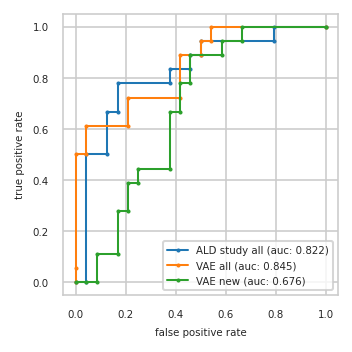

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.500   0.000 0.500   0.083 0.000
3          0.125 0.500   0.042 0.500   0.083 0.111
4          0.125 0.667   0.042 0.611   0.167 0.111
5          0.167 0.667   0.208 0.611   0.167 0.278
6          0.167 0.778   0.208 0.722   0.208 0.278
7          0.375 0.778   0.417 0.722   0.208 0.389
8          0.375 0.833   0.417 0.889   0.250 0.389
9          0.458 0.833   0.500 0.889   0.250 0.444
10         0.458 0.889   0.500 0.944   0.375 0.444
11         0.500 0.889   0.542 0.944   0.375 0.667
12         0.500 0.944   0.542 1.000   0.417 0.667
13         0.792 0.944   1.000 1.000   0.417 0.778
14         0.792 1.000     NaN   NaN   0.458 0.778
15         1.000 1.000     NaN   NaN   0.458 0.889
16           NaN   NaN     NaN   NaN   0.583 0.889
17           NaN   NaN     NaN   NaN   0.583 0.944
18           NaN   NaN     NaN   NaN   0.667 0.944
19           NaN   NaN     NaN   NaN   0.667 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A087X136;P51801,Q92765,Q8WYK1
2,G3V4U0;G3XA98;Q9UBX5,Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9U...,P51688
3,Q99983,Q9Y2T3;Q9Y2T3-3,P31321
4,P61981,P04075,J3KSJ8;Q9UD71;Q9UD71-2
5,P04075,P61981,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,P14174,C9JF17;P05090,Q96GD0
7,Q9Y2T3;Q9Y2T3-3,P63104,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P05413;S4R371,Q96GD0,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


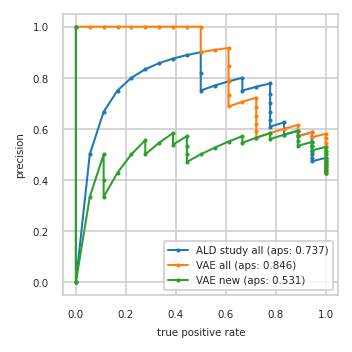

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.571 0.889     0.571 0.889     0.571 0.889
15         0.593 0.889     0.593 0.889     0.593 0.889
16         0.577 0.833     0.615 0.889     0.577 0.833
17         0.600 0.833     0.600 0.833     0.560 0.778
18         0.625 0.833     0.583 0.778     0.583 0.778
19         0.609 0.778     0.565 0.722     0.565 0.722
20         0.636 0.778     0.591 0.722     0.545 0.667
21         0.667 0.778     0.619 0.722     0.571 0.667
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.737 0.778     0.684 0.722     0.526 0.556
24         0.778 0.778     0.722 0.722     0.500 0.500
25         0.765 0.722     0.706 0.667     0.471 0.444
26         0.750 0.667     0.688 0.611     0.500 0.444
27         0.800 0.667     0.733 0.611     0.533 0.444
28         0.786 0.611     0.786 0.611     0.571 0.444
29         0.769 0.556     0.846 0.611     0.538 0.389
30         0.750 0.500     0.917 0.611     0.583 0.389
31         0.818 0.500     0.909 0.556     0.545 0.333
32         0.900 0.500     0.900 0.500     0.500 0.278
33         0.889 0.444     1.000 0.500     0.556 0.278
34         0.875 0.389     1.000 0.444     0.500 0.222
35         0.857 0.333     1.000 0.389     0.429 0.167
36         0.833 0.278     1.000 0.333     0.333 0.111
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


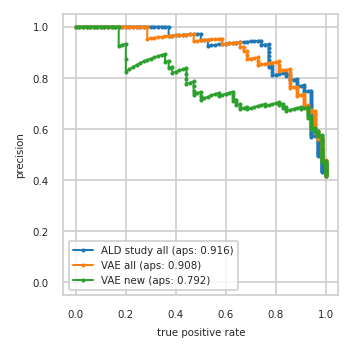

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


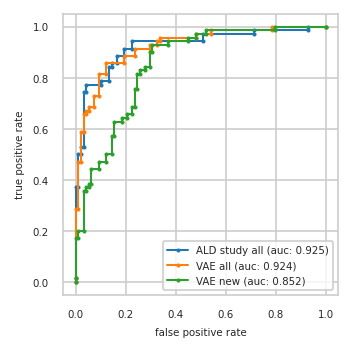

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}